In [3]:
import pandas as pd

# Load the dataset
data = pd.read_csv("gdb9_G4MP2_withdata_hydrogenation_clean.csv")

# Print the first few rows of the dataset
print(data.head())

  unsat_SMILE sat_SMILE     delta_H  nH2    pH2
0         C#C        CC  150.735206    2  13.42
1         C=O        CO   83.774454    1   6.29
2        CC#C       CCC  139.811813    2   9.15
3        CC=O       CCO   63.227291    1   4.38
4     CC(C)=O    CC(C)O   51.916637    1   3.36


In [10]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv("gdb9_G4MP2_withdata_hydrogenation_clean.csv")

# Convert SMILES to Morgan Fingerprints
def smiles_to_fps(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits))
    return np.zeros(nBits)

data['unsat_fps'] = data['unsat_SMILE'].apply(smiles_to_fps)

# Prepare input data
X = np.array(list(data['unsat_fps']))
X = np.hstack([X, data['nH2'].values.reshape(-1, 1)])  # Including nH2 as an additional feature

# Target data
y = data['delta_H'].values

# Normalize features and split data
X_scaler = StandardScaler().fit(X)
X = X_scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Neural Network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Mean Absolute Error on test data: {mae}")


Epoch 1/200
486/486 [==============================] - 4s 7ms/step - loss: 2576.6799 - mae: 37.2226 - val_loss: 728.9974 - val_mae: 19.4895
Epoch 2/200
486/486 [==============================] - 3s 6ms/step - loss: 965.1099 - mae: 23.0208 - val_loss: 531.1370 - val_mae: 16.5650
Epoch 3/200
486/486 [==============================] - 3s 6ms/step - loss: 766.2778 - mae: 20.6180 - val_loss: 464.0014 - val_mae: 15.8043
Epoch 4/200
486/486 [==============================] - 4s 9ms/step - loss: 703.4182 - mae: 19.7134 - val_loss: 426.5092 - val_mae: 15.0408
Epoch 5/200
486/486 [==============================] - 3s 6ms/step - loss: 642.0976 - mae: 18.9518 - val_loss: 384.1956 - val_mae: 14.0611
Epoch 6/200
486/486 [==============================] - 3s 6ms/step - loss: 590.8775 - mae: 18.2814 - val_loss: 355.0634 - val_mae: 13.7300
Epoch 7/200
486/486 [==============================] - 3s 6ms/step - loss: 553.3416 - mae: 17.6469 - val_loss: 316.5055 - val_mae: 12.8561
Epoch 8/200
486/486 [=====

122/122 [==============================] - 0s 2ms/step


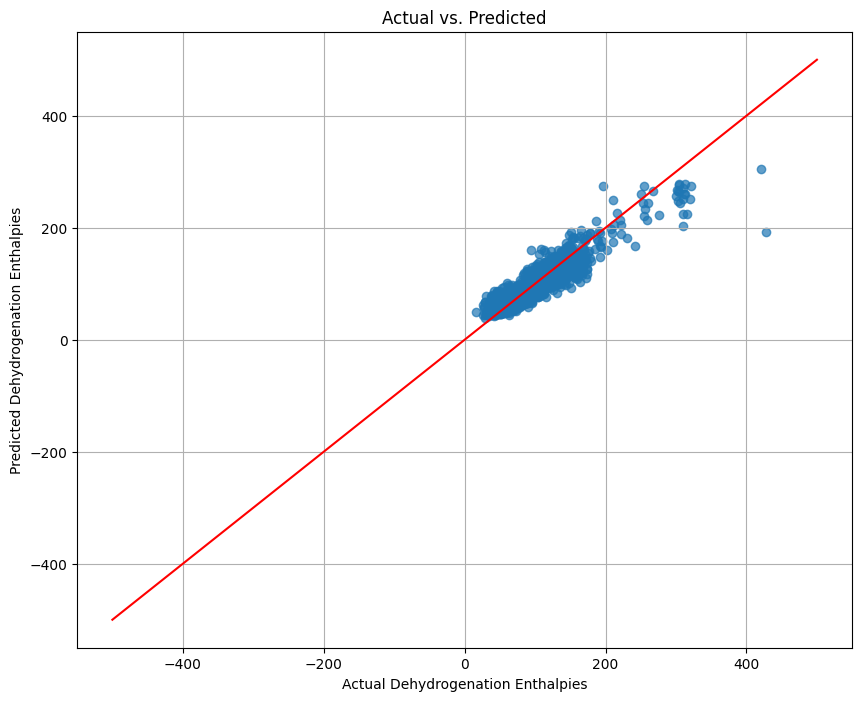

In [12]:
import matplotlib.pyplot as plt

# Generate predictions
y_pred = model.predict(X_test).flatten()

# Scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([-500, 500], [-500, 500], color='red')  # This line represents the y=x line to guide the eye
plt.xlabel('Actual Dehydrogenation Enthalpies')
plt.ylabel('Predicted Dehydrogenation Enthalpies')
plt.title('Actual vs. Predicted')
plt.grid(True)
plt.show()
